# Нейронные сети
- Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- Использовать CrossEntropyLoss и L2-регуляризацию.
- Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- (**+2 балла**) Добавить Batch normalization.
- (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- (**+1 балл**) Также реализовать оптимизатор Adam.

## Датасет
Для решения задачи был взят датасет http://ufldl.stanford.edu/housenumbers/, а именно уже разделенные тренировочные и тестовые данные, без учета дополнительных данных. В репозитории этого датасета нет из-за его большого размера (~ 182MB train и 64MB test)

In [1]:
!pip install --quiet matplotlib
!pip install --quiet numpy
!pip install --quiet pandas 
!pip install --quiet torch
!pip install --quiet torchvision

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from itertools import product
import pandas as pd

Подготовка датасета

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

raw_train_data = SVHN(
    root="../data/task07", 
    split='train', 
    download=True, 
    transform=transform)

test_data = SVHN(
    root="../data/task07", 
    split='test', 
    download=True, 
    transform=transform)

Создание loader-ов

In [4]:
raw_train_size = len(raw_train_data)
val_size = int(0.3 * raw_train_size)
train_size = raw_train_size - val_size

train_data, val_data = random_split(raw_train_data, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

## Слои сети

In [5]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0 / input_dim)))
        self.b = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        self._x = x
        return x @ self.W + self.b

    def backward(self, grad_out):
        grad_in = grad_out @ self.W.t()
        self.W.grad = self._x.t() @ grad_out
        self.b.grad = grad_out.sum(dim=0)
        return grad_in

In [6]:
class ReluLayer(nn.Module):
    def forward(self, x):
        self._x = x
        return F.relu(x)
    
    def backward(self, grad_output):
        grad_input = grad_output.clone()
        grad_input[self._x <= 0] = 0
        return grad_input

Нейронная сеть

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, dim_hidden=128, use_bn=False):
        super().__init__()
        self.use_bn = use_bn
        self.layer_in = FullyConnectedLayer(3 * 32 * 32, dim_hidden)
        self.activation = ReluLayer()
        self.bn_layer = nn.BatchNorm1d(dim_hidden) if use_bn else None
        self.layer_out = FullyConnectedLayer(dim_hidden, 10)

    def forward(self, inputs):
        reshaped = inputs.view(-1, 3 * 32 * 32)
        out = self.layer_in(reshaped)
        out = self.activation(out)
        if self.use_bn:
            out = self.bn_layer(out)
        out = self.layer_out(out)
        return out

## Оптимизатор Adam

In [8]:
class AdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.states = []
        for p in self.params:
            if p.requires_grad:
                state = {
                    'm': torch.zeros_like(p.data),
                    'v': torch.zeros_like(p.data),
                    't': 0
                }
                self.states.append(state)
            else:
                self.states.append(None)
        
        self.t = 0 

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        
        for param, state in zip(self.params, self.states):
            if param.grad is None or state is None:
                continue
                
            grad = param.grad.data
            
            if self.weight_decay != 0:
                grad += self.weight_decay * param.data

            state['m'] *= beta1
            state['m'] += (1 - beta1) * grad
            state['v'] *= beta2
            state['v'] += (1 - beta2) * grad * grad
            
            m_hat = state['m'] / (1 - beta1 ** self.t)
            v_hat = state['v'] / (1 - beta2 ** self.t)
            
            param.data -= self.lr * m_hat / (v_hat.sqrt() + self.eps)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

## Проверка корректности вычисления градиента

In [9]:
def check_gradient(model, inputs, targets, criterion, delta=1e-3, num_checks=15):
    model.eval()
    model.zero_grad()
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backward()
    
    param_list = [p for p in model.parameters() if p.requires_grad and p.grad is not None]
    total_params = sum(p.numel() for p in param_list)
    
    if total_params == 0:
        return True

    for param in param_list:
        param_data_flat = param.data.view(-1)
        param_grad_flat = param.grad.view(-1)
        num_elems = param_data_flat.numel()
        n_checks = max(1, int(num_checks * num_elems / total_params))
        indices = torch.randperm(num_elems)[:n_checks]
        
        for idx in indices:
            original_value = param_data_flat[idx].item()
            
            with torch.no_grad():
                param_data_flat[idx] = original_value + delta
                loss_plus = criterion(model(inputs), targets).item()
                
                param_data_flat[idx] = original_value - delta
                loss_minus = criterion(model(inputs), targets).item()
                
                param_data_flat[idx] = original_value

            estimated_grad = (loss_plus - loss_minus) / (2 * delta)
            actual_grad = param_grad_flat[idx].item()

            if abs(estimated_grad - actual_grad) > delta:
                print(f'Gradient check failed at index {idx}: estimated {estimated_grad}, actual {actual_grad}')
                return False

    return True

## Обучение 

In [10]:
devide = device = torch.device('cpu')
epochs=6

def train(model, train_loader, val_loader, criterion, optimizer):
    train_loss = []
    val_loss = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        
        # Gradient check on one batch from train_loader
        batch = next(iter(train_loader))
        if not check_gradient(model, *batch, criterion):
            raise ValueError('Gradient is calculated incorrectly') 
    
    return train_loss, val_loss


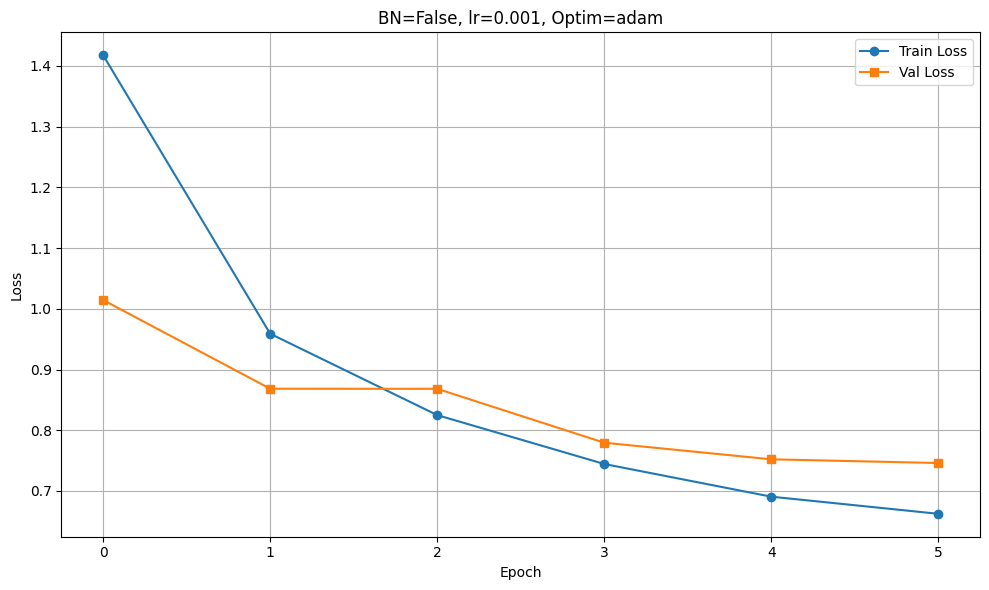

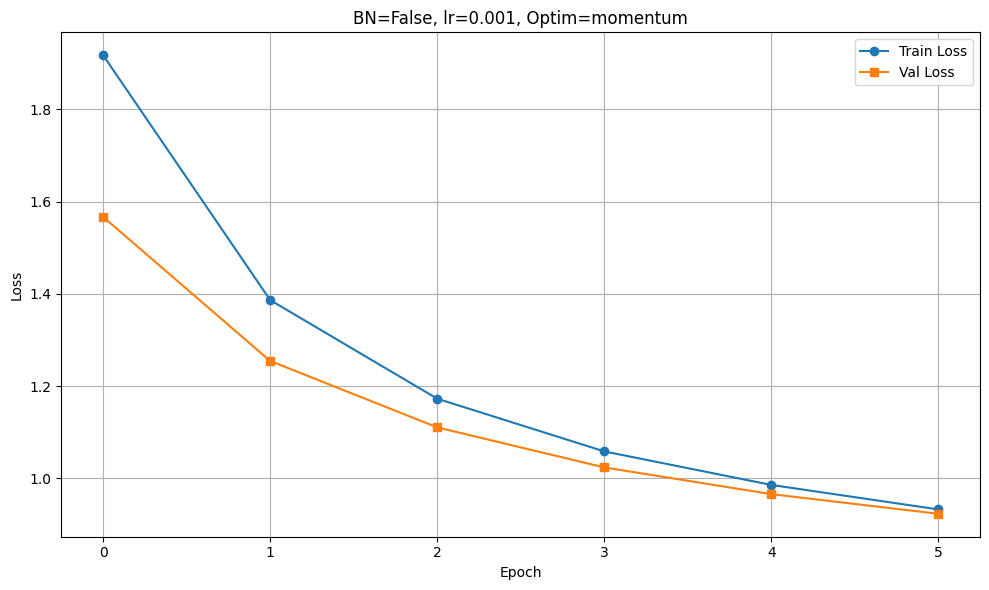

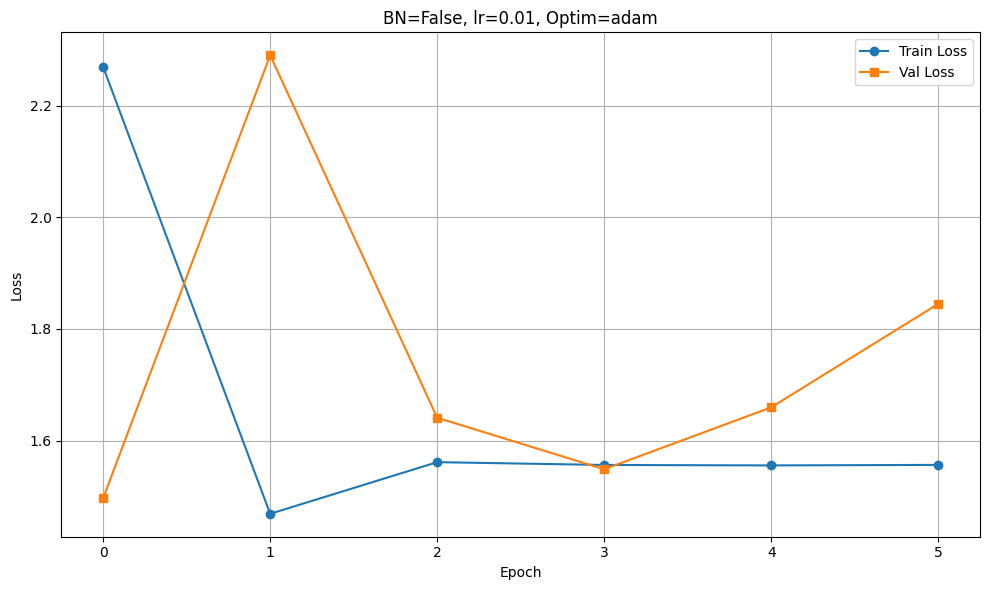

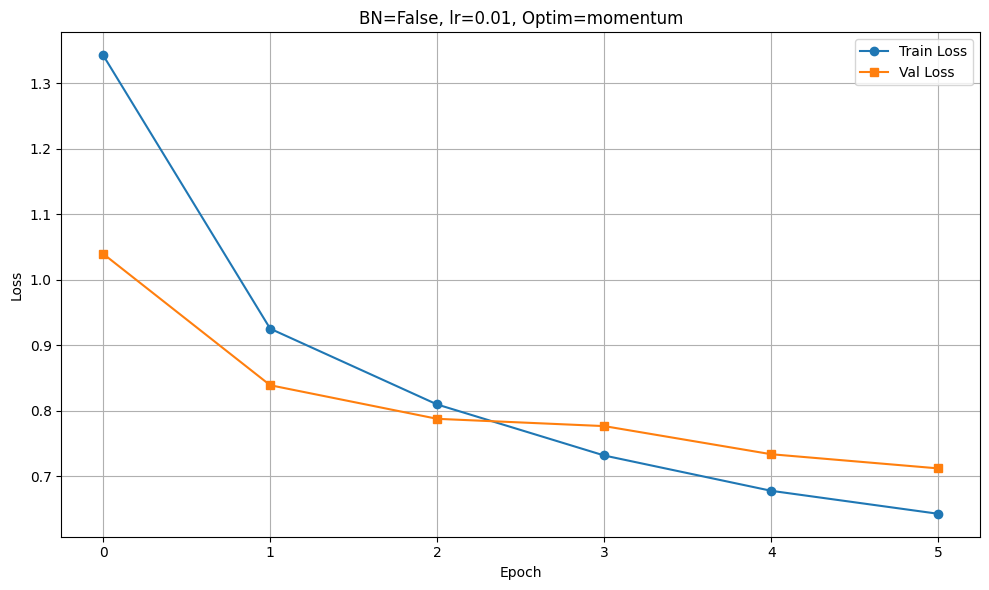

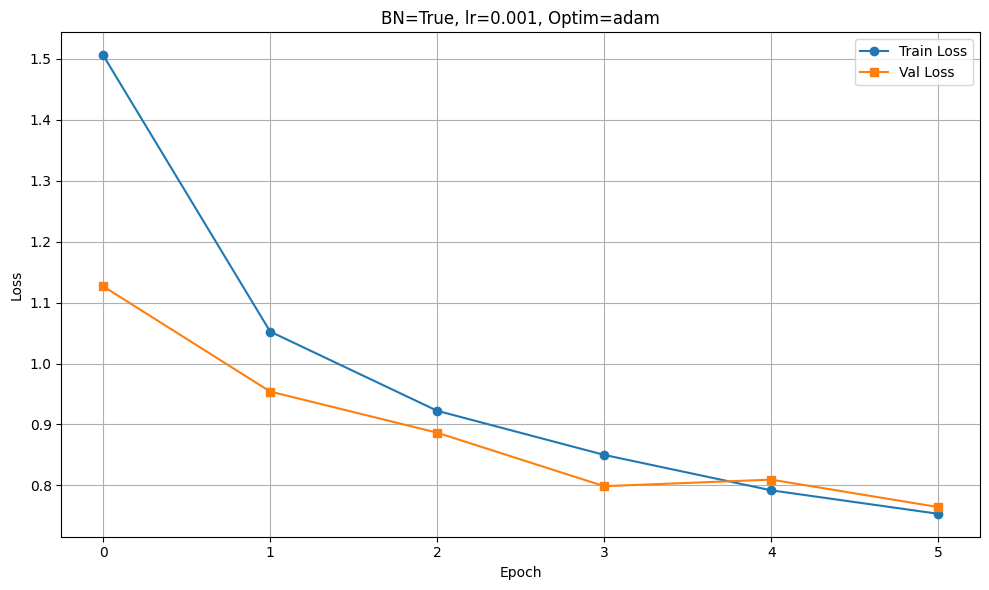

Gradient check failed at index 105320: estimated 0.0022649765014648438, actual 0.0037012400571256876
Experiment failed: Gradient is calculated incorrectly


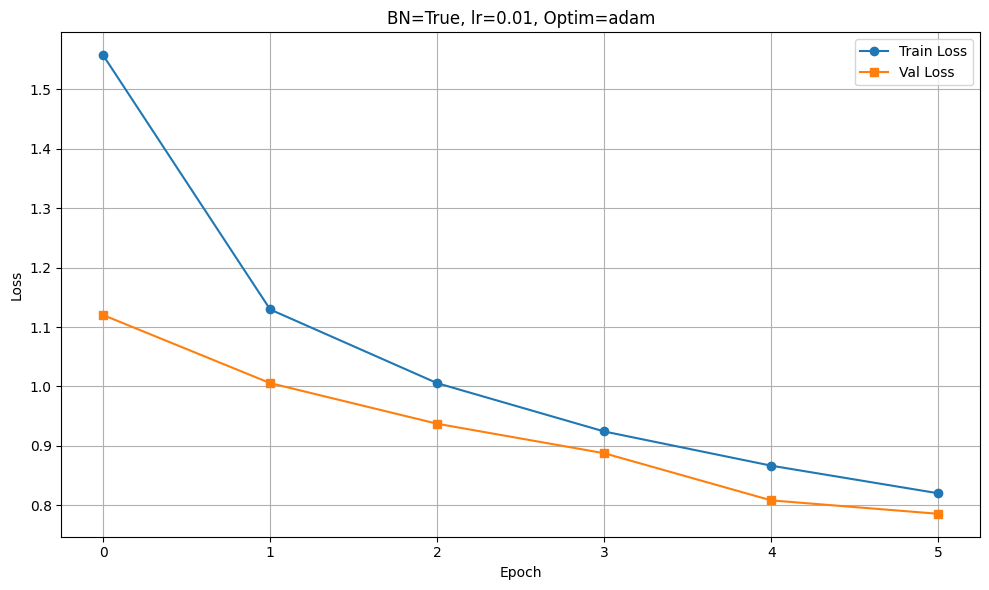

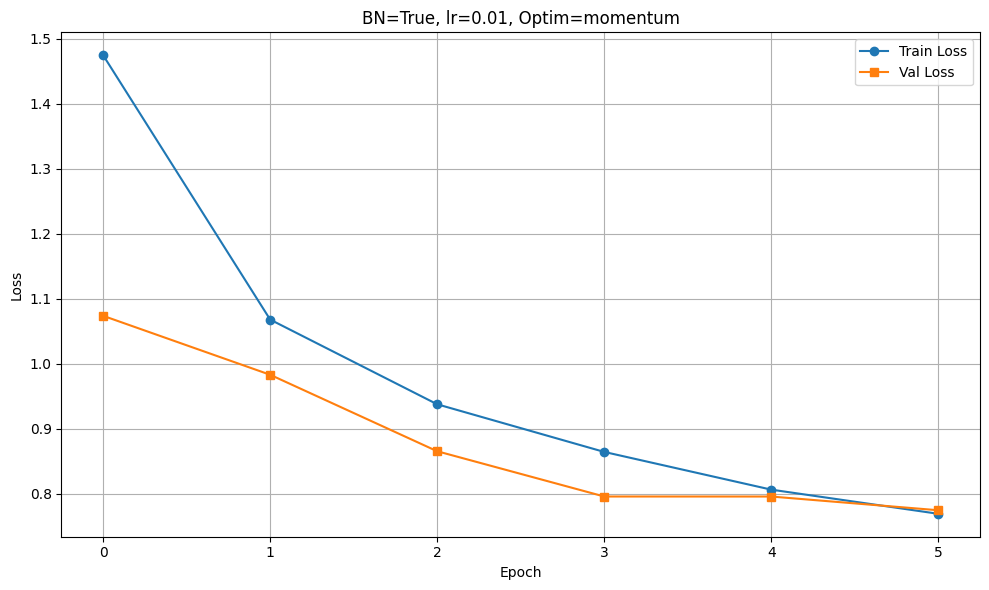

In [11]:
def get_optimizer(name: str, params, lr: float, **kwargs):
    # Returns the optimizer instance based on the provided name.
    name = name.lower()
    if name == 'adam':
        return AdamOptimizer(params, lr=lr, **kwargs)
    elif name == 'momentum':
        return optim.SGD(params, lr=lr, momentum=0.9, **kwargs)
    elif name == 'sgd':
        return optim.SGD(params, lr=lr, **kwargs)
    else:
        raise ValueError(f"Unsupported optimizer: {name}")

def run_experiments(models, lrs, optimizers, train_loader, val_loader):
    results = []
    for model_config, lr, opt_name in product(models, lrs, optimizers):
        model = NeuralNetwork(use_bn=model_config['use_bn']).to(device)
        
        if model_config.get('seed') is not None:
            torch.manual_seed(model_config['seed'])
            model.apply(init_weights)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = get_optimizer(opt_name, model.parameters(), lr)
        
        try:
            train_loss, val_loss = train(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer
            )
            
            results.append({
                'model_type': 'BN' if model_config['use_bn'] else 'NoBN',
                'lr': lr,
                'optimizer': opt_name,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'final_train_loss': train_loss[-1],
                'final_val_loss': val_loss[-1]
            })
            
            plot_losses(train_loss, val_loss, model_config, lr, opt_name)
        except Exception as e:
            print(f"Experiment failed: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

def plot_losses(train_loss, val_loss, model_config, lr, optim_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Val Loss', marker='s')
    plt.title(f"BN={model_config['use_bn']}, lr={lr}, Optim={optim_name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

experiment_config = {
    'models': [{'use_bn': False, 'seed': 0}, {'use_bn': True, 'seed': 0}],
    'lrs': [0.001, 0.01],
    'optimizers': ['adam', 'momentum']
}

results = run_experiments(
    models=experiment_config['models'],
    lrs=experiment_config['lrs'],
    optimizers=experiment_config['optimizers'],
    train_loader=train_loader,
    val_loader=val_loader
)

## Результаты 

In [12]:
results

,model_type,lr,optimizer,train_loss,val_loss,final_train_loss,final_val_loss
0,NoBN,0.001,adam,"[1.4173810479795546, 0.9588763023403815, 0.824...","[1.0143241315733555, 0.8683688309650088, 0.868...",0.662433,0.746034
1,NoBN,0.001,momentum,"[1.9175709429524486, 1.386617998604168, 1.1728...","[1.5668946012508038, 1.2546035370161368, 1.110...",0.932650,0.923144
2,NoBN,0.010,adam,"[2.269054642862215, 1.46915827316239, 1.561601...","[1.497267549294372, 2.289983259730561, 1.64107...",1.556684,1.844996
3,NoBN,0.010,momentum,"[1.3423992851725837, 0.9252250778333208, 0.809...","[1.0394526756433553, 0.8389541161961334, 0.787...",0.642781,0.712055
4,BN,0.001,adam,"[1.5055034395465232, 1.052339031734966, 0.9224...","[1.1266097485326056, 0.9540038086300673, 0.886...",0.753525,0.764517
5,BN,0.010,adam,"[1.5573343880604626, 1.1295135096272924, 1.005...","[1.120136906414531, 1.0055868999902593, 0.9372...",0.820183,0.785679
6,BN,0.010,momentum,"[1.4744804544639112, 1.0677224058016874, 0.937...","[1.0735195802394735, 0.9828090587154378, 0.865...",0.768887,0.774348


Модель с использованием Batch Normalization и при learning rate = 0.001 с оптимизатором Adam показала наилучший результат (train: 0.651107, val: 0.715368)